# Local models

#### Libraries 

In [66]:
import numpy as np
import os.path
import glob
import pandas as pd

from io import BytesIO
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from sklearn.metrics import mean_absolute_error

from matplotlib import pyplot as plt

from scipy.stats import multivariate_normal
from scipy.stats import pearsonr

from scipy.stats import gamma
from scipy.stats import wishart

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

In [39]:
title_font = {'family':'Arial', 'size': 20, 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size': 16}


#### Data 

In [30]:
path_name_train = 'Data\\20100802S1_ECoG_Motion6'
path_name_test = 'Data\\20100726S1_ECoG_Motion6'

In [32]:
def get_ecog(dir):
    #n_ch - number of channels
    n_ch = len(glob.glob(os.path.join(dir, 'ECoG_ch*.mat')))
    ECoG = []
    for ch in range(1, n_ch + 1):
        ECoGData = loadmat(os.path.join(dir, 'ECoG_ch%d.mat' % ch))
        ECoGData = ECoGData['ECoGData_ch%d' % ch]
        ECoG.append(ECoGData[0])

    ECoG = np.array(ECoG)
    
    Time = loadmat(os.path.join(dir, 'ECoG_time.mat'))
    Time = Time['ECoGTime']

    return ECoG.T, Time.T

In [140]:
def get_ecog_and_motions(dir):
    n_ch = len(glob.glob(os.path.join(dir, 'ECoG_ch*.mat')))
    ECoG = []
    for ch in range(1, n_ch + 1):
        ECoGData = loadmat(os.path.join(dir, 'ECoG_ch%d.mat' % ch))
        ECoGData = ECoGData['ECoGData_ch%d' % ch]
        ECoG.append(ECoGData[0])

    ECoG = np.array(ECoG)

    Motion = loadmat(os.path.join(dir, 'Motion.mat'))
    MotionTime = Motion['MotionTime']
    Motion = Motion['MotionData']
        
    LSHO = Motion[0,:]
    LELB = Motion[1,:]
    LWRI = Motion[2,:]
    RSHO = Motion[3,:]
    RELB = Motion[4,:]
    RWRI = Motion[5,:]
    
    Time = loadmat(os.path.join(dir, 'ECoG_time.mat'))
    Time = Time['ECoGTime']

    return ECoG.T, LSHO[0], LELB[0], LWRI[0], RSHO[0], RELB[0], RWRI[0], Time.T, MotionTime.T

In [141]:
def extract_needed_data(ECoG, LSHO, LELB, LWRI, RSHO, RELB, RWRI, Time, MotionTime):
    
    body_center = (LSHO - RSHO)/2 #It is a static point in this experiment
    motion_left_hand = LWRI - body_center #centering motion
    
    return ECoG, motion_left_hand

In [142]:
def synchronize_interpol(signal_data, motion_data): 
    start = max(signal_data[1, 0],motion_data[1,0])
    end = min(signal_data[-1, 0],motion_data[-1,0])

    #cutting signal and motion, only overlapping time left
    signal_data = signal_data[:,:][(signal_data[:,0]>=start)]
    signal_data = signal_data[:,:][(signal_data[:,0]<=end)]
    motion_data = motion_data[:,:][motion_data[:,0]>= start] 
    motion_data = motion_data[:,:][motion_data[:,0]<= end]
    M = []
    #signal and motion have different time stamps, we need to synchronise them
    #interpolating motion and calculating arm position in moments of "signal time"
    for i in range(1,motion_data.shape[1]):
        interpol = interp1d(motion_data[:,0],motion_data[:,i],kind="cubic")
        x = interpol(signal_data[:,0])
        M.append(x)

    #downsampling in 10 times to get faster calcultions

    ecog_signal = signal_data[::10,1:]
    motion = np.array(M).T[::10,:]
    time = signal_data[::10,0]
    
    
    #self.signal = signal_data[:,1:]
    #self.motion = np.array(M).T[:,:]
    #self.time = signal_data[:,0]

    return ecog_signal, motion, time

In [36]:
# data for the first type of train|test split
data_train, time_train = get_ecog(path_name_train)
data_test, time_test = get_ecog(path_name_test)
#df = pd.DataFrame(data)

In [37]:
#(x,y) coordinates for channels 1-64 based on the image of places (b.png)
#centers[i] -coordinates of the i channel

centers = [(4,1), (6, 1), \
           (3, 2), (5, 2), (7,2),\
           (2,3), (4, 3), (6, 3), \
           (1, 4), (3, 4), (5, 4), (7, 4),\
           (2, 5), (4, 5), (6, 5), (8, 5),\
           (1, 6), (3, 6), (5, 6), (7, 6),\
           (2, 7), (4, 7), (6, 7), (8, 7),\
           (1, 8), (3, 8), (5, 8), (7, 8),\
           (2, 9), (4, 9), (6, 9), (8, 9),\
           (1, 10), (3, 10), (5, 10), (7, 10),\
           (2, 11), (4, 11), (6, 11), (8, 11),\
           (1, 12), (3, 12), (5, 12), (7, 12),\
           (2, 13), (4, 13), (6, 13), (8, 13),\
           (1, 14), (3, 14), (5, 14), (7, 14),\
           (2, 15), (4, 15), (6, 15), (8, 15),\
           (1, 16), (3, 16), (5, 16), (7, 16),\
           (2, 17), (4, 17), (6, 17), (8, 17)]

### Raw ECoG 

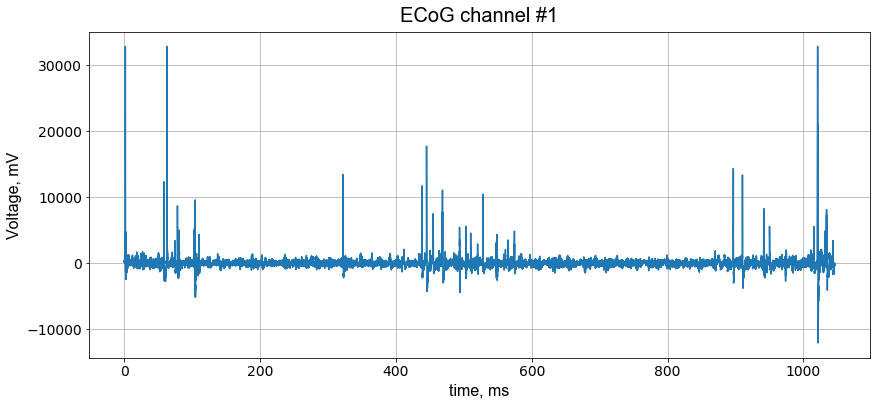

In [40]:
plt.figure(figsize=(14,6))
plt.plot(time_train, data_train[:,0])
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.title('ECoG channel #1', **title_font)
plt.xlabel('time, ms', **axis_font)
plt.ylabel('Voltage, mV', **axis_font)
plt.grid(True)
plt.show()
plt.close()

In [41]:
data = data_train
time = time_train

In [42]:
# number of values taken for observation
N = 100000

#### Gauss hypothesis

Определяем функции, которые находят среднее, дисперсию и функцию, которая получает нормировочную константу интенсивности в зависимости от найденного среднего

In [43]:
def get_mean(ECoG, time):
    mean = []
    intens = 0
    for j in range(len(time)):
        intens_sum = 0
        x, y = 0, 0
        for i in range(64):
            center_x, center_y = centers[i]
            intens = abs(ECoG[j,i])
            intens_sum += intens
            x += center_x * intens
            y += center_y * intens
            
        mean.append([x / intens_sum, y / intens_sum])
        
    return np.array(mean)


def get_disp(mean, ECoG, time):
    disp = []
    for j in range(len(time)):
        mean_x, mean_y = mean[j]
        intens_sum = 0
        disp_x, disp_y = 0, 0
        for i in range(64):
            center_x, center_y = centers[i]
            intens = abs(ECoG[j, i])
            intens_sum += intens
            disp_x += (center_x - mean_x)**2 * intens
            disp_y += (center_y - mean_y)**2 * intens

        disp.append([disp_x / intens_sum, disp_y / intens_sum])
    return np.array(disp)


def get_intens(mean, disp, mv, ECoG, time):
    intens = []
    for j in range(len(time)):
        mean_x, mean_y = mean[j]
        # Adjust our mean to integer points we have in centers
        x = int(round(mean_x))
        y = int(round(mean_y))
        if (x, y) in centers:
            i = centers.index((x,y))
        else:
            if y<17:
                y = y+1
            else:
                y = y-1
            i = centers.index((x,y))
        i = 0;
        
        pred_int = mv[j].pdf(centers[0])
        intens.append(ECoG[j,i]/pred_int)
    return intens

In [128]:
#Normalize data

scaler = StandardScaler()
scaler.fit(data)
data_n = scaler.transform(data)
data_normed = normalize(data)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Считаем параметры нормального распределения

In [83]:
%%time
m = get_mean(data_n[:N], time[:N])
d = get_disp(m, data_n[:N], time[:N])

Wall time: 15.7 s


In [130]:
m_normed = get_mean(data_normed[:N], time[:N])
d_normed = get_disp(m, data_normed[:N], time[:N])

Восстанавливаем по параметрам $\mu$ и $\sigma^2$ распределение сигнала в каждый момент времени

In [135]:
%%time
#Calcuate bivariate normal distribution for each moment of time

mv = []
for i in range(len(m)):
    mv.append(multivariate_normal([m[i, 0], m[i, 1]], [[d[i,0], 0], [0, d[i, 1]]]))


Wall time: 14.2 s


In [137]:
%%time
mv_normed = []
for i in range(len(m_normed)):
    mv_normed.append(multivariate_normal([m_normed[i, 0], m_normed[i, 1]], [[d_normed[i,0], 0], [0, d_normed[i, 1]]]))


Wall time: 14.7 s


Считаем на всякий случай отношение реальной интенсивности сигнала  к полученному в восстановленном распределении в средней точке

In [85]:
%%time
intens = get_intens(m, d, mv, data[:N], time[:N])

Wall time: 2.73 s


In [ ]:
%%time
#Calculating mae and potting local models from standardized data with fitted additionnaly with intensity with original raw data
mae_intens = []
for channel in range(len(centers)):
    point = centers[channel]
    rv = []
    
    for j in range(len(mv)):
            p = mv[j].pdf(point)
            rv.append(p*intens[j])
    mae_intens.append(mean_absolute_error(rv, data[:N, channel]))
    
    fig, ax1 = plt.subplots(1,1, figsize = (14, 8))
    color = 'tab:green'
    ax1.set_xlabel('time (ms)', **axis_font)
    ax1.set_ylabel('predicted', color=color, **axis_font)
    ax1.plot(time[:N], rv, color=color, alpha = 0.5)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('true', color=color, **axis_font) 
    ax2.plot(time[:N], data[:N, channel], color=color, alpha = 0.5)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Gauss local model for first 100000 entries \n channel #%i' %channel , **title_font)
    plt.savefig(r'C:\Users\User\Documents\diploma_plots\Gauss_'+str(channel))
    plt.close()

In [113]:
%%time
#Calculating mae and potting local models with standardized data
mae_no_intens = []
for channel in range(len(centers)):
    point = centers[channel]
    rv = []
    
    for j in range(len(mv)):
            p = mv[j].pdf(point)
            rv.append(p)
    mae_no_intens.append(mean_absolute_error(rv, data_n[:N, channel]))     
    fig, ax1 = plt.subplots(1,1, figsize = (14, 8))
    color = 'tab:green'
    ax1.set_xlabel('time (ms)', **axis_font)
    ax1.set_ylabel('predicted', color=color, **axis_font)
    ax1.plot(time[:N], rv, color=color, alpha = 0.5)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('true', color=color, **axis_font) 
    ax2.plot(time[:N], data_n[:N, channel], color=color, alpha = 0.5)    
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Gauss local model for first 100000 entries \n channel #%i' %channel , **title_font)
    plt.savefig(r'C:\Users\User\Documents\diploma_plots\Gauss_no_intens'+str(channel))
    plt.close()

In [138]:
%%time
#Calculating mae and potting local models with normalized data
mae_normed = []
for channel in range(len(centers)):
    point = centers[channel]
    rv = []
    
    for j in range(len(mv_normed)):
            p = mv_normed[j].pdf(point)
            rv.append(p)
    mae_normed.append(mean_absolute_error(rv, data_normed[:N, channel]))     
    fig, ax1 = plt.subplots(1,1, figsize = (14, 8))
    color = 'tab:green'
    ax1.set_xlabel('time (ms)', **axis_font)
    ax1.set_ylabel('predicted', color=color, **axis_font)
    ax1.plot(time[:N], rv, color=color, alpha = 0.5)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('true', color=color, **axis_font) 
    ax2.plot(time[:N], data_normed[:N, channel], color=color, alpha = 0.5)    
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Gauss local model for first 100000 entries \n channel #%i' %channel , **title_font)
    plt.savefig(r'C:\Users\User\Documents\diploma_plots\Gauss_normed'+str(channel))
    plt.close()

Wall time: 2min 38s


In [107]:
mean_absolute_error(rv, data_n[:N, channel])

0.5654385746288237

In [116]:
np.array(mae_intens).mean()

668.9705082827852

In [109]:
mae_no_intens = []
#mae = []
for channel in range(len(centers)):
    point = centers[channel]
    rv = []
    
    for j in range(len(mv)):
            p = mv[j].pdf(point)
            rv.append(p)   
    mae_no_intens.append(mean_absolute_error(rv, data_n[:N, channel]))

In [117]:
np.array(mae_no_intens).mean()

0.5330008503539042

Рассмотреть движение

### Gamma hypothesys

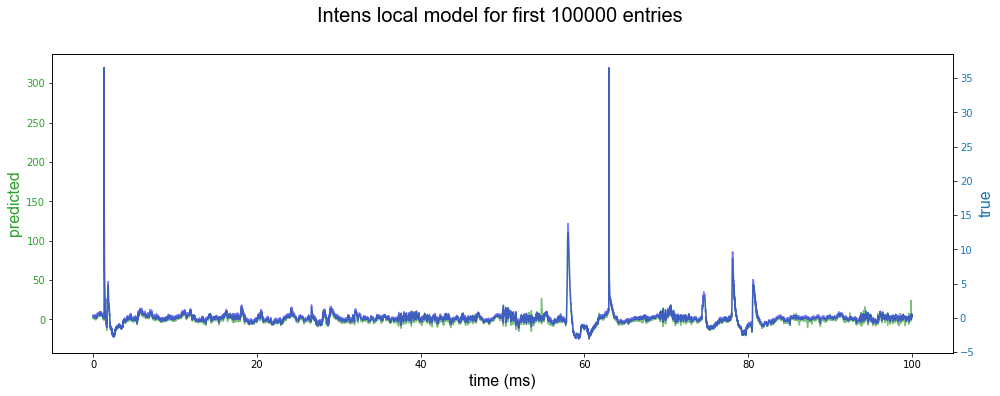

In [151]:
for channel in range(1):
    #point = centers[channel]
    g_d = []
    for j in range(len(m)):
        p = wishart.pdf(point, 2, [[m[j, 0], 0], [0, m[j, 1]]])
        g_d.append(p*intens[j])
    
    fig, ax1 = plt.subplots(1,1, figsize = (14, 5))
    color = 'tab:green'
    ax1.set_xlabel('time (ms)', **axis_font)
    ax1.set_ylabel('predicted', color=color, **axis_font)
    ax1.plot(time[:N], (np.array(g_d)[:N]), color='green', alpha = 0.5)
    #ax1.plot(time[20000:40000], (np.array(g_d)[20000:40000]), color='green', alpha = 0.5)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('true', color=color, **axis_font) 
    ax2.plot(time[:N], (data_n[:N, channel]), color='blue', alpha = 0.5)
    #ax2.plot(time[20000:40000], (data[20000:40000, channel]), color='blue', alpha = 0.5)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
      
    plt.title('Intens local model for first %i entries \n' %N , **title_font)
    
    plt.show()

Непосредственно восстановить ECoG пданными локальными моделями нам не удастся. Однако, посмотрим на ключевую задачу: сокращение признакового пространства. Можем ли мы сократить кол-во признаков сырых данных с 64 до 5, то есть в восемь раз? Если сравнивать наши результаты и результаты Мотренко, то размерность пространства сокращается с $F\times N \times T$ до $5 \times T$, то есть в $\frac{F \times N}{5}$ раз. Учитывая, что частотных диапазонов 15 (ссылка на код мотренко), то снижение размерности составляет в 320 раз.

Рассмотрим предсказание движения.

In [145]:
ECoG, LSHO, LELB, LWRI, RSHO, RELB, RWRI, time, motion_time =  get_ecog_and_motions(path_name_train)
x, y = extract_needed_data(ECoG, LSHO, LELB, LWRI, RSHO, RELB, RWRI, time, motion_time)

In [149]:
signal_data = np.c_[time, x]
motion_data = np.c_[motion_time, y]

MemoryError: 

In [ ]:
ecog_signal, motion, time = synchronize_interpol(signal_data, motion_data)

In [150]:
scaler = StandardScaler()
scaler.fit(ecog_signal)
data_n = scaler.transform(ecog_signal)
m = get_mean(data_n[:N], time[:N])
d = get_disp(m, data_n[:N], time[:N])
intens = get_intens(m, d, mv, data[:N], time[:N])

NameError: name 'ecog_signal' is not defined

In [ ]:
X = np.c_[m, d, intens]

In [ ]:
model = PLSRegression(n_components = 50)
model.fit(X,motion)
Y_pred = model.predict(X)


In [ ]:
plt.figure(figsize = (15,6))
plt.plot(time,Y_pred[:,0])
plt.plot(time,motion[10000:,0])

In [ ]:
r2score(motion[10000:], Y_pred)